### Input networks from different data sources

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, pickle, subprocess
from networks import bio_networks, utils
from create_datasets import create_nx_datasets, create_splits

**1. Obtain genes of interest**

Using DisGeNET to get Gene-Disease-Associations (GDAs) to Alzheimer's Disease (AD gene set) and other neurodegenerative diseases (ND).

In [ ]:
subprocess.call ("genes_of_interest/get_GDAs.R")

**2. Obtain biological networks**

Obtain new biological networks for the AD gene set from different sources:
1. STRING: Protein-Protein Interactions (PPIs)
2. BioGRID: Protein-Protein Interactions (PPIs)
3. Human Reference Interactome (HuRI): PPIs
4. PPT-Ohmnet dataset from Stanford Network Analysis Project (SNAP): brain-specific PPIs
5. GIANT: functional network, brain-specific

In [ ]:
# STRING (PPI)
print('STRING')
edgelist_string = bio_networks.get_string('data/AD_GDAs.tsv')
print()

# BioGRID (PPI)
print('BioGRID')
edgelist_biogrid = bio_networks.get_biogrid('data/AD_GDAs.txt')
print()

# HuRI (PPI) - HuRI interactions were downloaded from HuRI webpage and then parsed to obtain the corresponding edgelist.
print('HuRI')
edgelist_huri = bio_networks.get_huri('data/other_networks/HuRI_download_interactions_dec_16_2021_11_54_03.csv')
print()

# PPT-Ohmnet (PPI, brain-specific)
print('PPT-Ohmnet')
network_snap = bio_networks.get_snap('data/AD_GDAs.txt')
print()

# GIANT (functional network, brain-specific)
print('GIANT')
network_giant = bio_networks.get_giant('data/AD_GDAs.txt')
print()

**2. Create graph datasets**

Create the correspoding graph-datasets for each newly obtained biological network.

In [2]:
dataset = 'ADNI'
targets = ['PET', 'PETandDX']
networks = ['string', 'biogrid', 'huri', 'snap_brain', 'giant_brain']

for target in targets:
    for network in networks:

        outdir = f'data/graph_datasets/{target}'

        result_nodes = create_nx_datasets.main('data', dataset, target, 'AD', network, 'missense', None)
        outfile = f'{outdir}/AD_PPI_{network}_missense_pyg.pkl'
        print('Resulting dataset saved at:', outfile)
        print()

        with open(outfile, 'wb') as f:
            pickle.dump(result_nodes, f)

data/AD_STRING_PPI_edgelist.txt
Network used: AD string
# nodes = 59
# edges = 115

Dataset used: ADNI
missense
(59, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 52 # edges = 111
Density = 0.083710407239819 Diameter = 6
Resulting dataset saved at: data/graph_datasets/PET/AD_PPI_string_missense_pyg.pkl

Network used: AD biogrid
# nodes = 46
# edges = 62

Dataset used: ADNI
missense
(46, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 38 # edges = 57
Density = 0.08108108108108109 Diameter = 5
Resulting dataset saved at: data/graph_datasets/PET/AD_PPI_biogrid_missense_pyg.pkl

Network used: AD huri
# nodes = 18
# edges = 16

Dataset used: ADNI
missense
(18, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 12 # edges = 13
Density = 0.19696969696969696 Diameter = 6
Resulting dataset saved at: data/gr

In [ ]:
# Create splits for using it in GraphGym and non-GNN models
# Splits are obtained through 10-Fold Stratied Cross Validation

create_splits.create_folds_stratified_cv('PET', 10)
create_splits.create_folds_stratified_cv('PETandDX', 10)

**3. Graph classification with GNNs**

We then evaluated and tested different GNNs in the framework called [GraphGym](https://github.com/snap-stanford/GraphGym) (You *et al.*, 2020).

Configuration and grid files employed are in the subdirectory [graphgym_files](graphgym_files).

Summarized results obtained by GraphGym and other models are in **COMPLETE**

This section evaluates significance between the results that obtained different best GNN configs for each biological network.

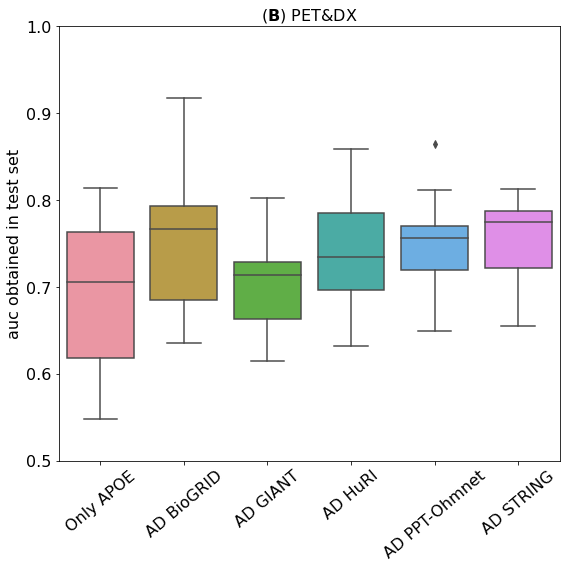

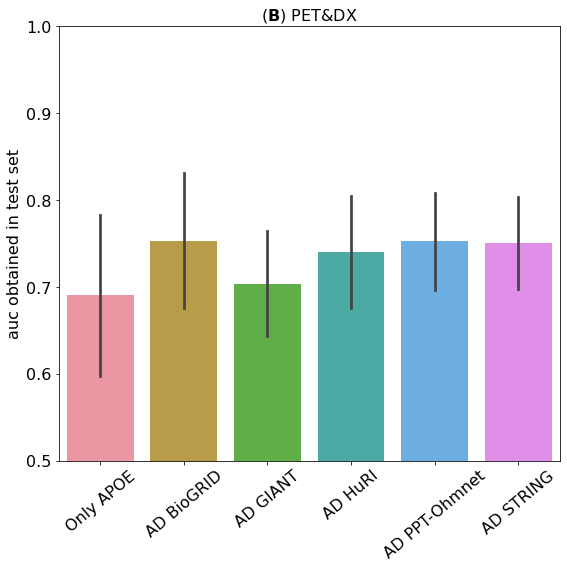

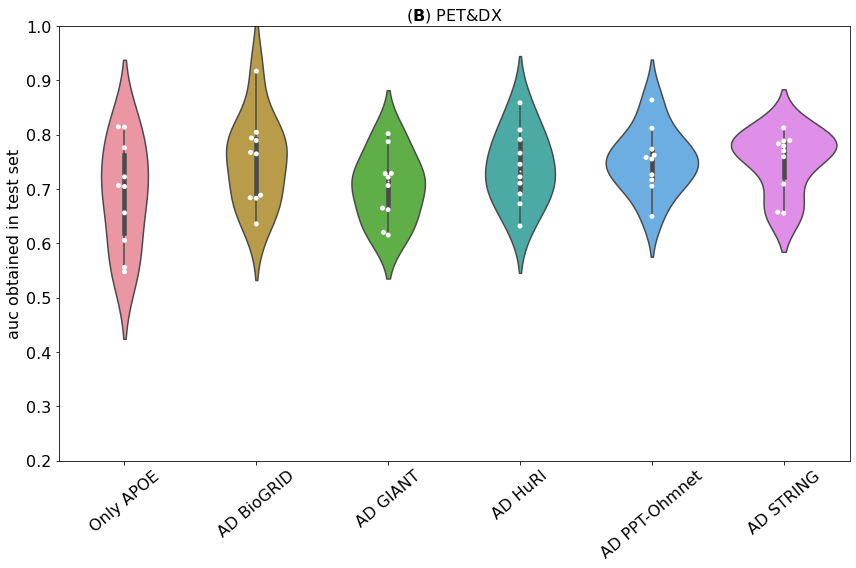

In [2]:
petdx_results = pd.read_csv('results/2022_03_networks_PETandDX.csv')
utils.boxplot_comparision_others('PETandDX', petdx_results, 'auc', r"($\bf{B}$) PET&DX")
utils.barplot_comparision_others('PETandDX', petdx_results, 'auc', r"($\bf{B}$) PET&DX")
utils.violinplot_comparision_others('PETandDX', petdx_results, 'auc', r"($\bf{B}$) PET&DX")

In [3]:
pvalues = utils.statistics(petdx_results)
print(pvalues)

{'AD PPT-Ohmnet': 0.051717255609973756, 'AD STRING': 0.05469058028620656, 'AD BioGRID': 0.06926328684824597, 'AD HuRI': 0.10254157203420601, 'AD GIANT': 0.3604574252913516, 'Only APOE': 0.5}


In [12]:
petdx_results['auc_mean'] = petdx_results.groupby(['dataset', 'model', 'target'])['auc'].transform('mean')
petdx_results['auc_std'] = petdx_results.groupby(['dataset', 'model'])['auc'].transform('std')
petdx_results

,fold,target,dataset,model,acc,pre,rec,f1,auc,Unnamed: 9,mean,auc_mean,auc_std
0,1,PET,Only APOE,Logistic Regression,0.657534,0.625000,0.975610,0.761905,0.727896,"[[8, 24], [1, 40]]",0.069063,0.640551,0.069063
1,2,PET,Only APOE,Logistic Regression,0.575342,0.583333,0.853659,0.693069,0.637576,"[[7, 25], [6, 35]]",0.069063,0.640551,0.069063
2,3,PET,Only APOE,Logistic Regression,0.561644,0.636364,0.512195,0.567568,0.545732,"[[20, 12], [20, 21]]",0.069063,0.640551,0.069063
3,4,PET,Only APOE,Logistic Regression,0.547945,0.562500,0.878049,0.685714,0.688262,"[[4, 28], [5, 36]]",0.069063,0.640551,0.069063
4,5,PET,Only APOE,Logistic Regression,0.616438,0.600000,0.951220,0.735849,0.762957,"[[6, 26], [2, 39]]",0.069063,0.640551,0.069063
5,6,PET,Only APOE,Logistic Regression,0.616438,0.724138,0.512195,0.600000,0.615473,"[[24, 8], [20, 21]]",0.069063,0.640551,0.069063
6,7,PET,Only APOE,Logistic Regression,0.597222,0.588235,0.975610,0.733945,0.588120,"[[3, 28], [1, 40]]",0.069063,0.640551,0.069063
7,8,PET,Only APOE,Logistic Regression,0.666667,0.774194,0.585366,0.666667,0.656570,"[[24, 7], [17, 24]]",0.069063,0.640551,0.069063
8,9,PET,Only APOE,Logistic Regression,0.569444,0.666667,0.487805,0.563380,0.574351,"[[21, 10], [21, 20]]",0.069063,0.640551,0.069063
9,10,PET,Only APOE,Logistic Regression,0.583333,0.584615,0.926829,0.716981,0.608576,"[[4, 27], [3, 38]]",0.069063,0.640551,0.069063


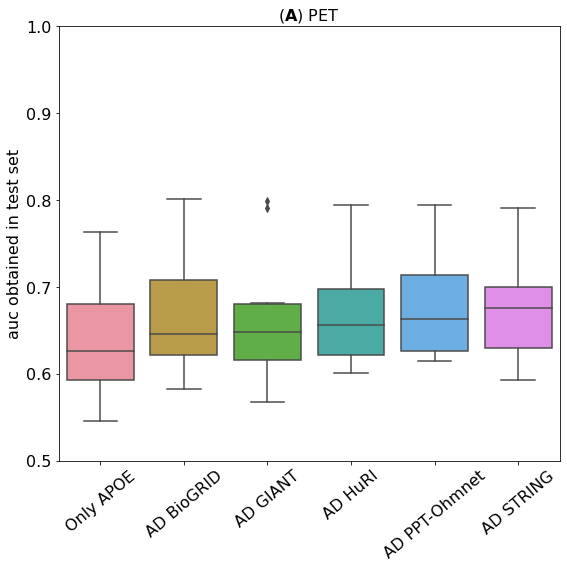

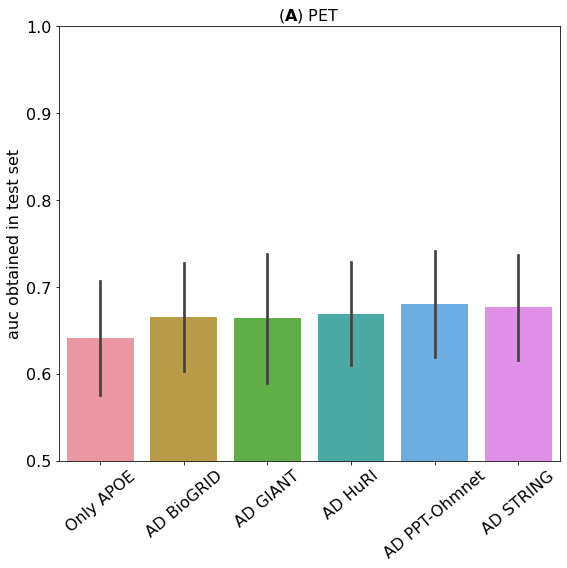

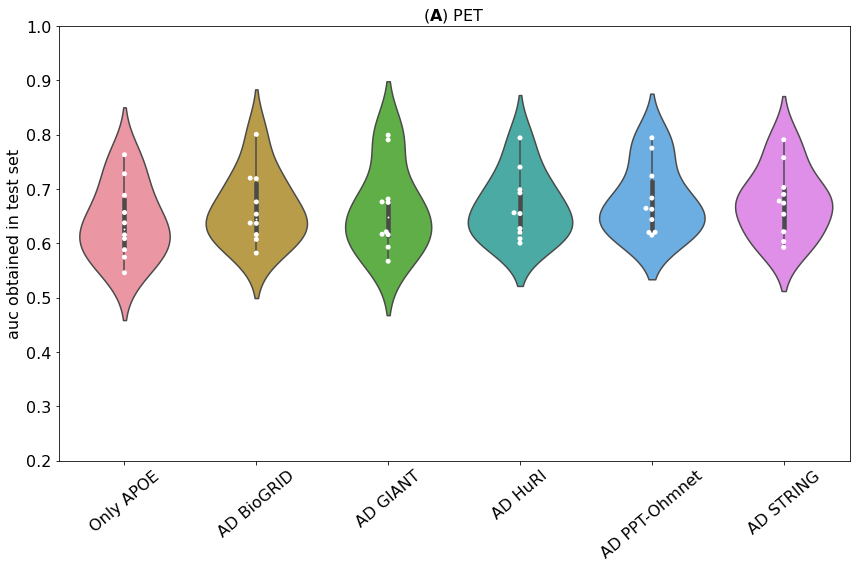

In [13]:
petdx_results = pd.read_csv('results/2022_03_networks_PET.csv')
utils.boxplot_comparision_others('PET', petdx_results, 'auc', r"($\bf{A}$) PET")
utils.barplot_comparision_others('PET', petdx_results, 'auc', r"($\bf{A}$) PET")
utils.violinplot_comparision_others('PET', petdx_results, 'auc', r"($\bf{A}$) PET")

In [3]:
pvalues = utils.statistics(petdx_results)
print(pvalues)

{'AD PPT-Ohmnet': 0.10071607071645536, 'AD STRING': 0.12241840380211852, 'AD HuRI': 0.17181326452204604, 'AD BioGRID': 0.21595301121112814, 'AD GIANT': 0.2485419526815798, 'Only APOE': 0.5}
